In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import joblib


In [4]:
data_path = r"C:\Users\Admin\DataMining\data"
df = pd.read_csv(data_path)

### Détection et traitement des outliers

#### Visualisation univariée

##### par Barplot

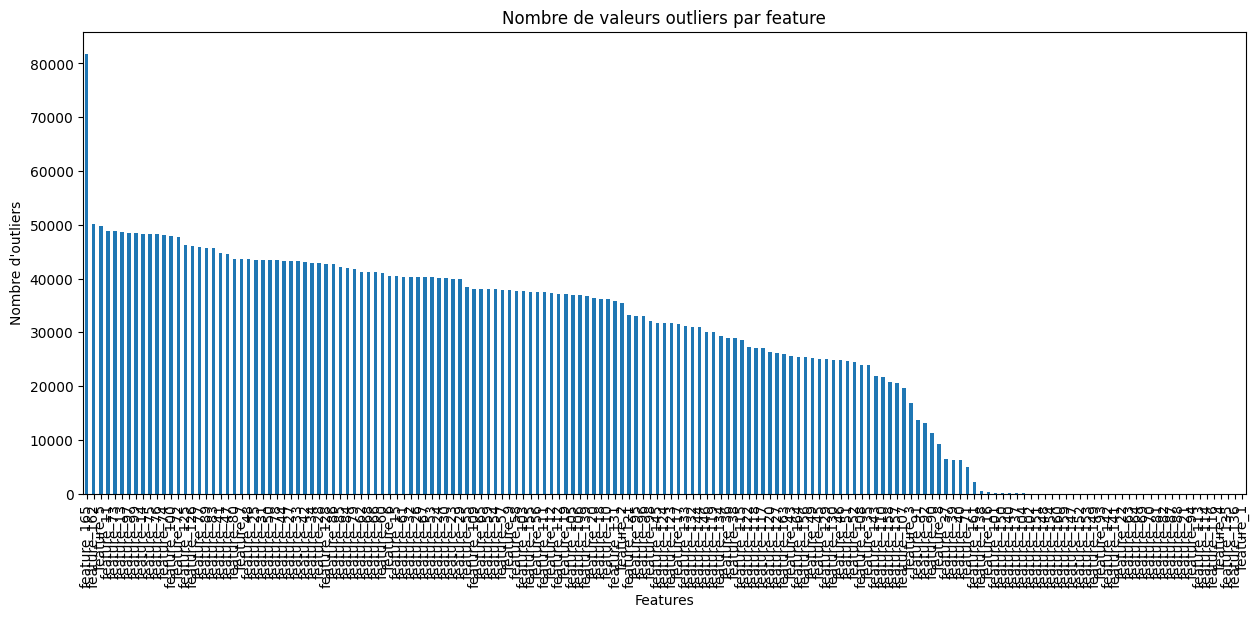

In [7]:
features = [f'feature_{i}' for i in range(1, 166)]
Q1 = df[features].quantile(0.25)
Q3 = df[features].quantile(0.75)
IQR = Q3 - Q1

# 🔹 Détection des outliers par feature
outliers_mask = (df[features] < (Q1 - 1.5*IQR)) | (df[features] > (Q3 + 1.5*IQR))
outliers_count = outliers_mask.sum()

# 🔹 Barplot synthétique du nombre d'outliers par feature
plt.figure(figsize=(15,6))
outliers_count.sort_values(ascending=False).plot(kind='bar')
plt.title("Nombre de valeurs outliers par feature")
plt.ylabel("Nombre d'outliers")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.show()

##### par boxplot

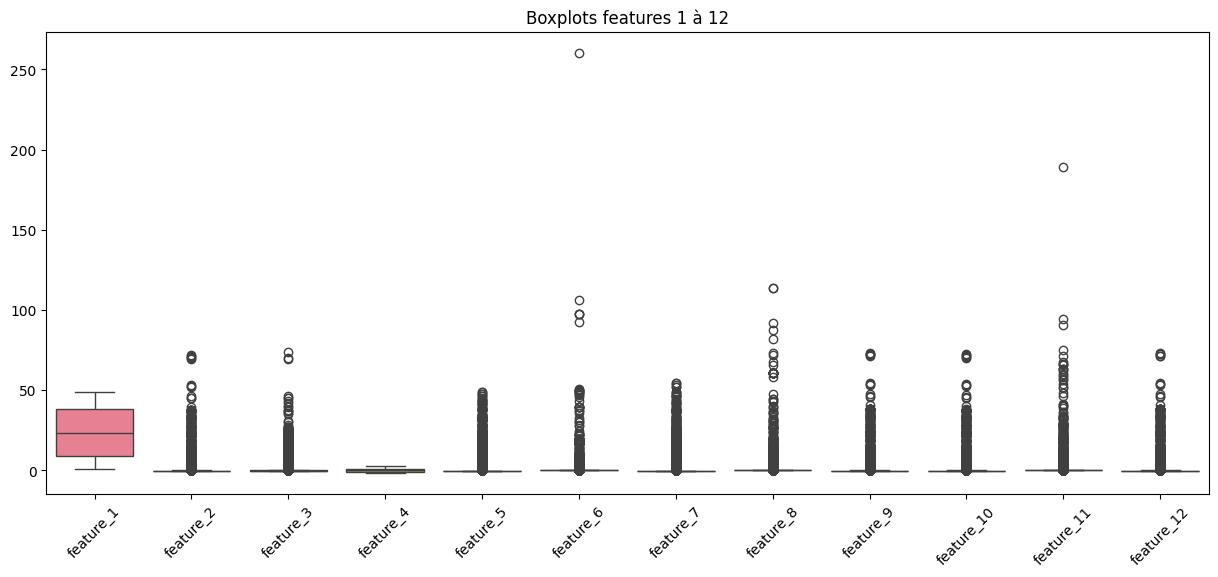

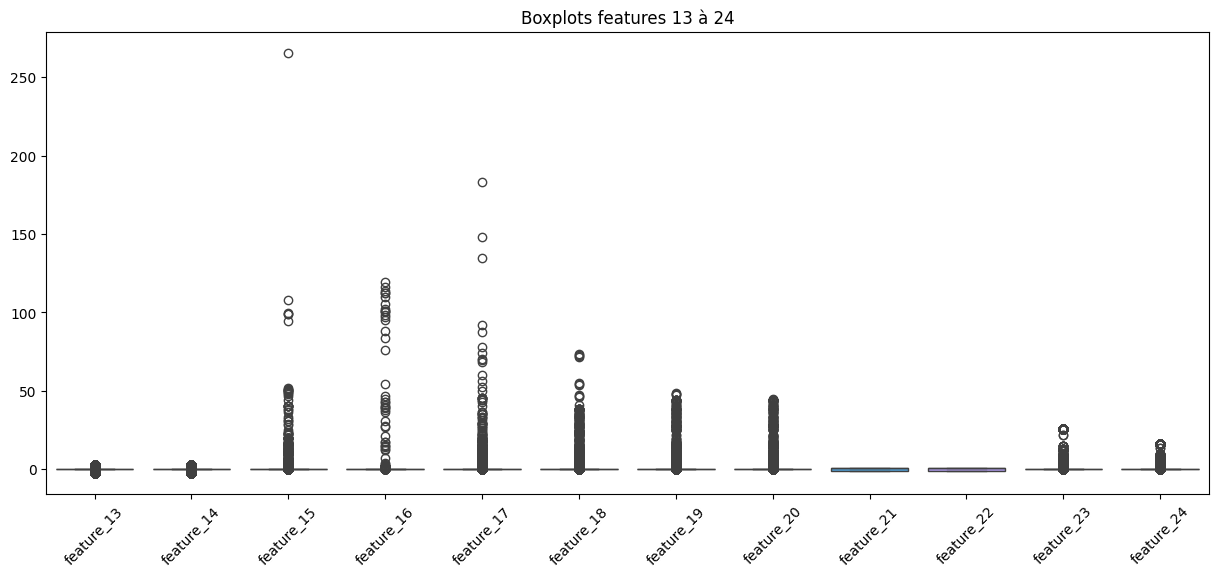

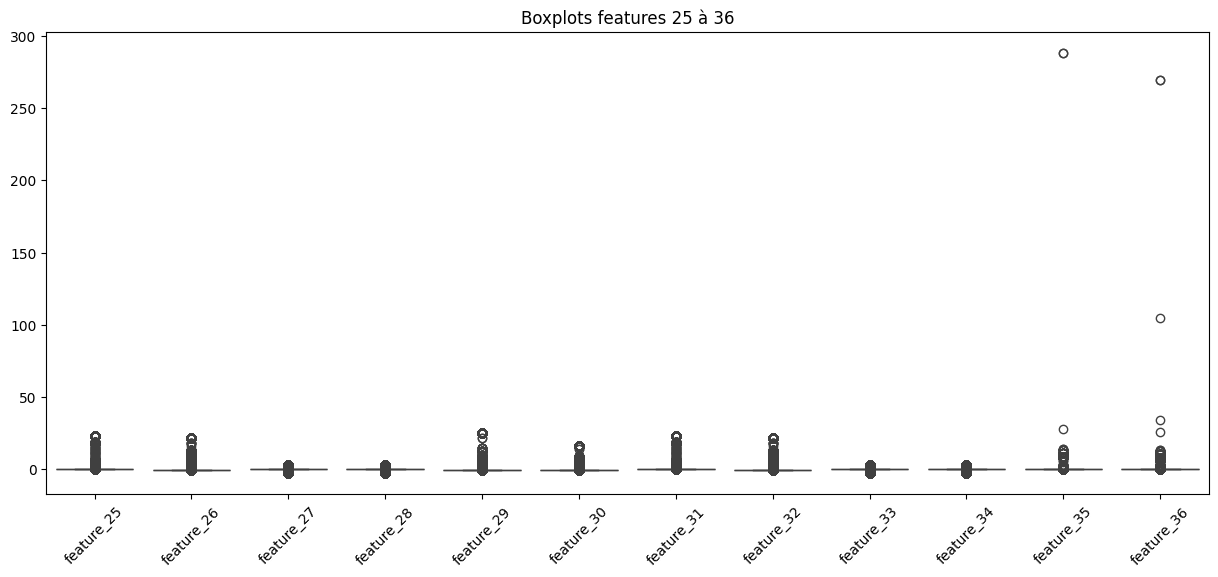

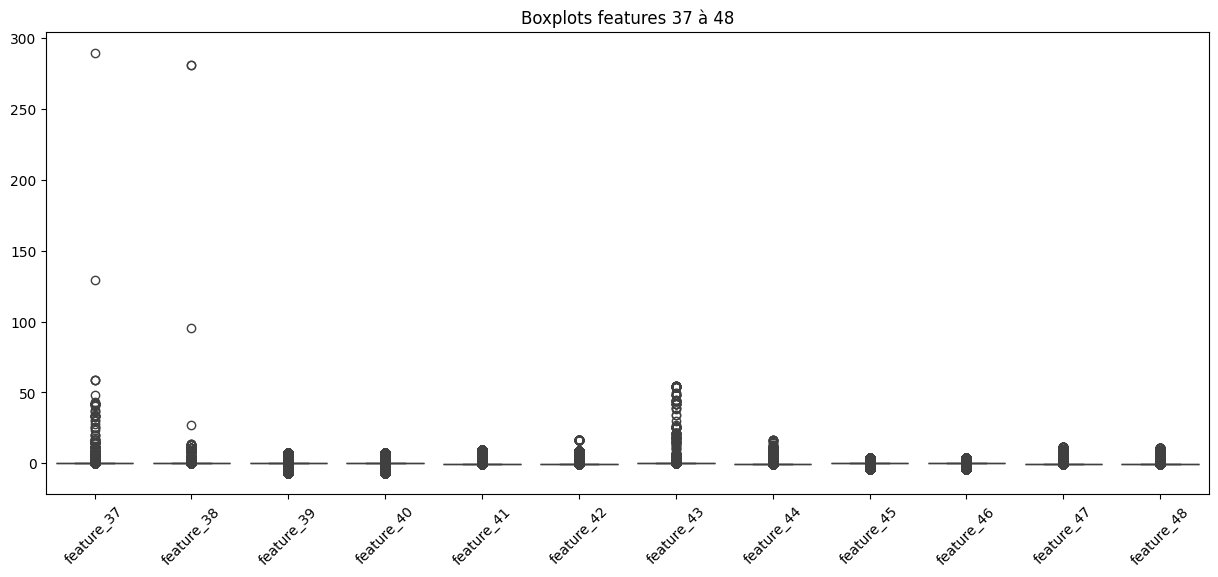

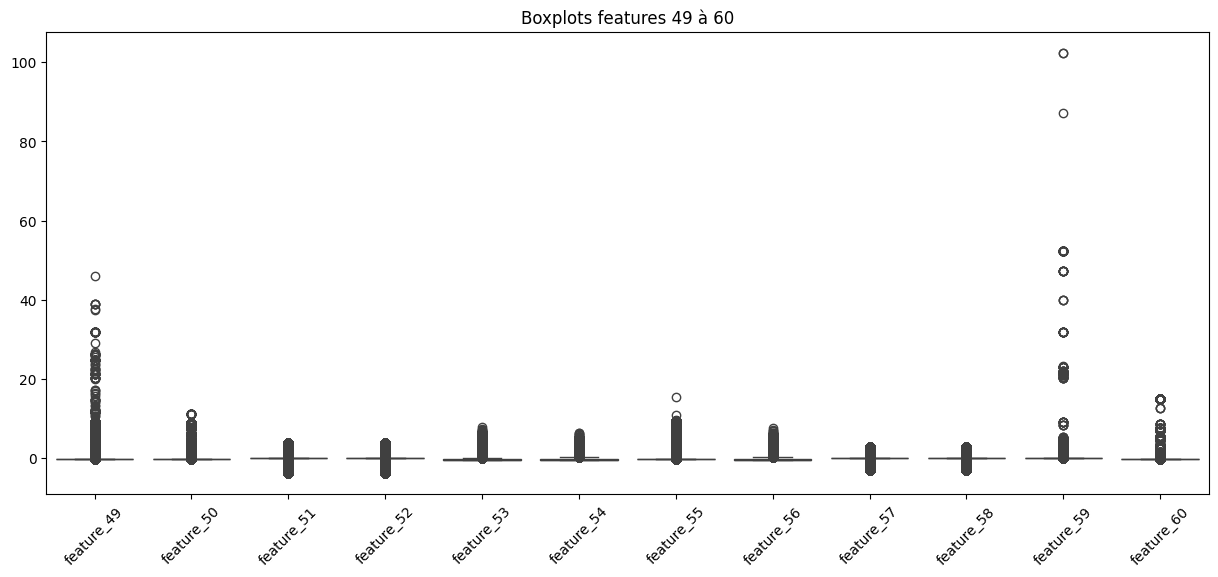

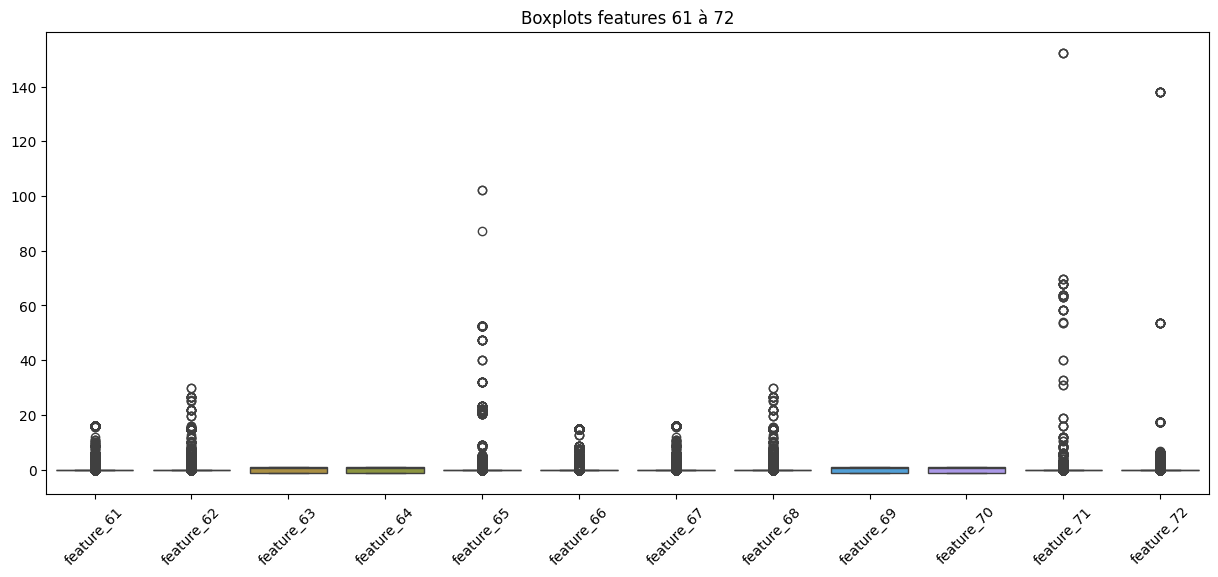

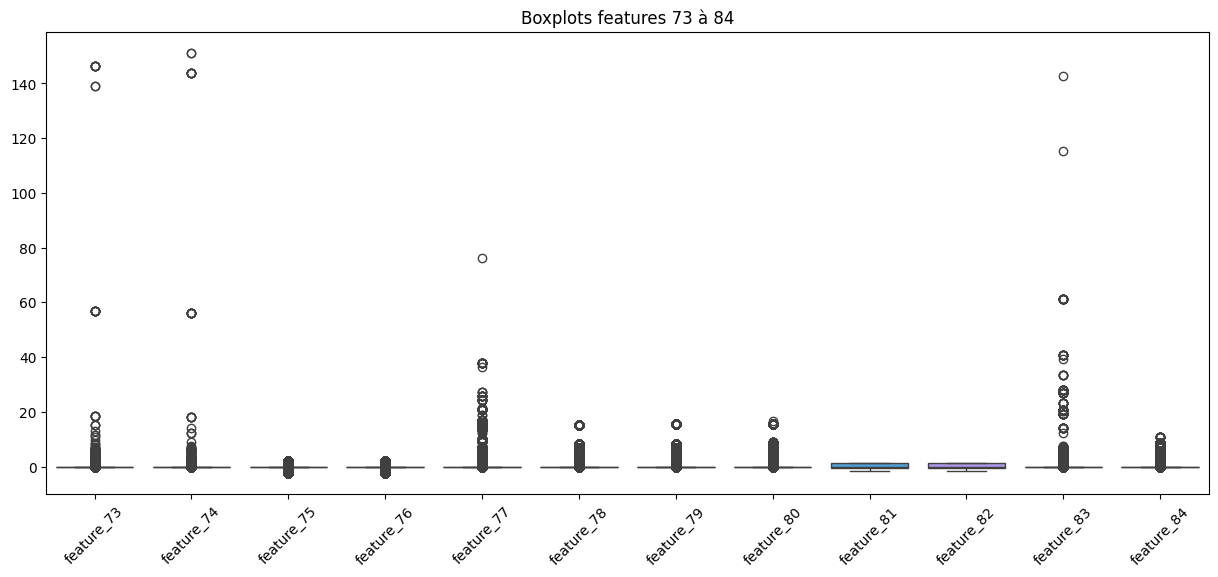

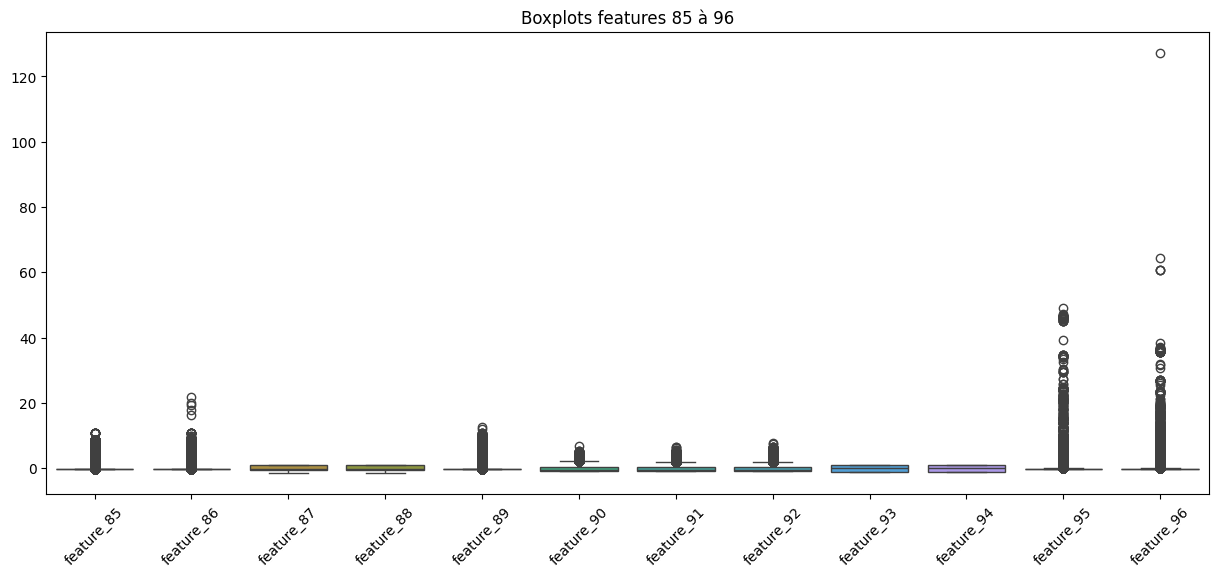

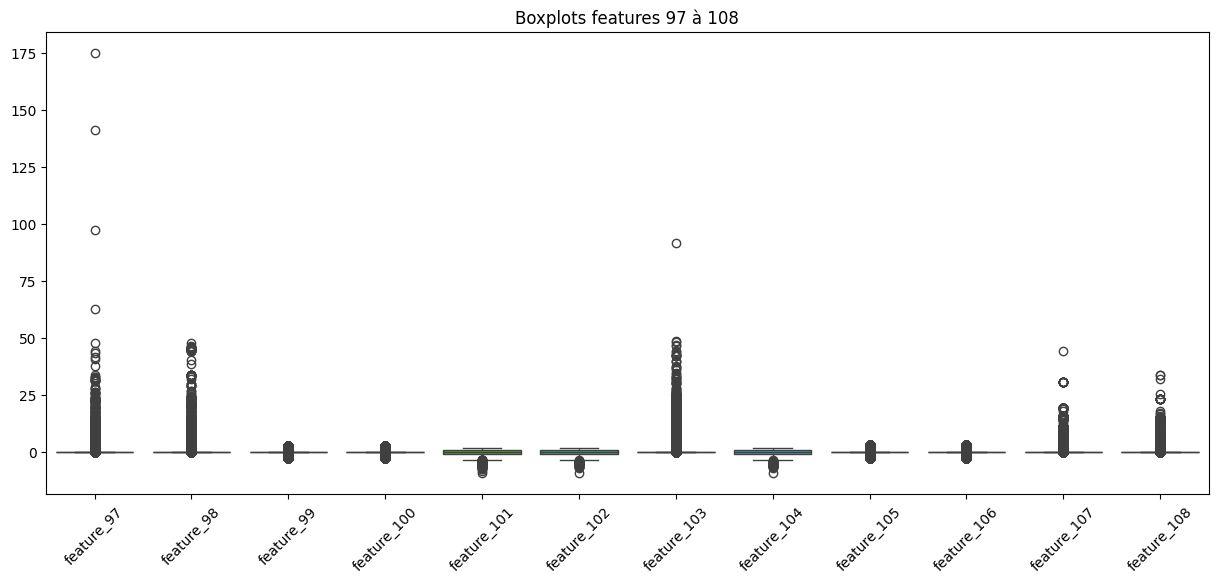

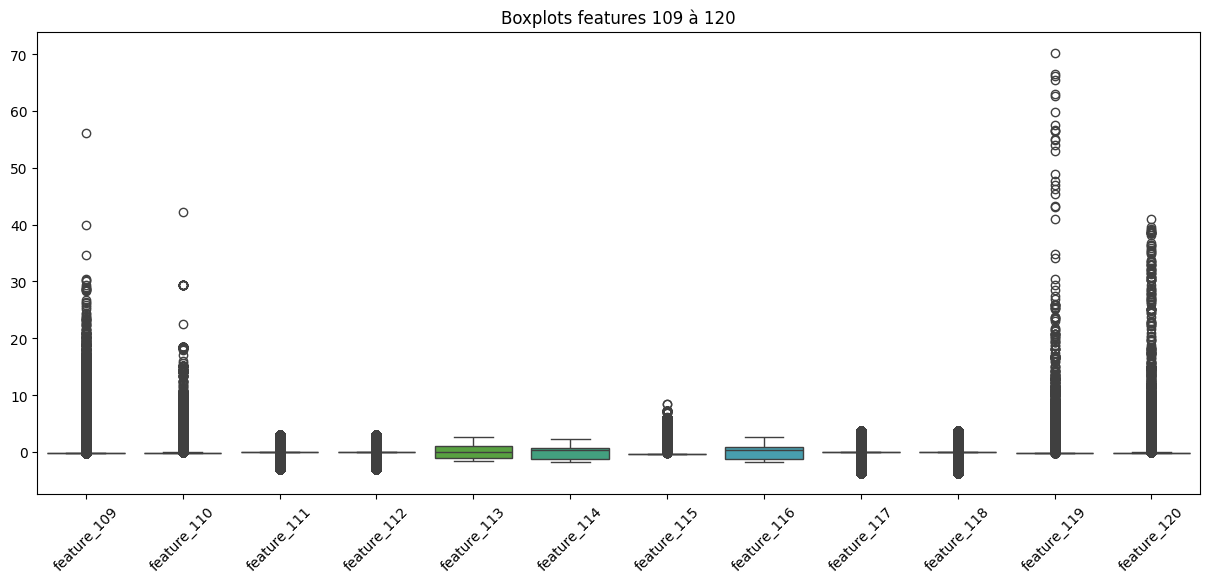

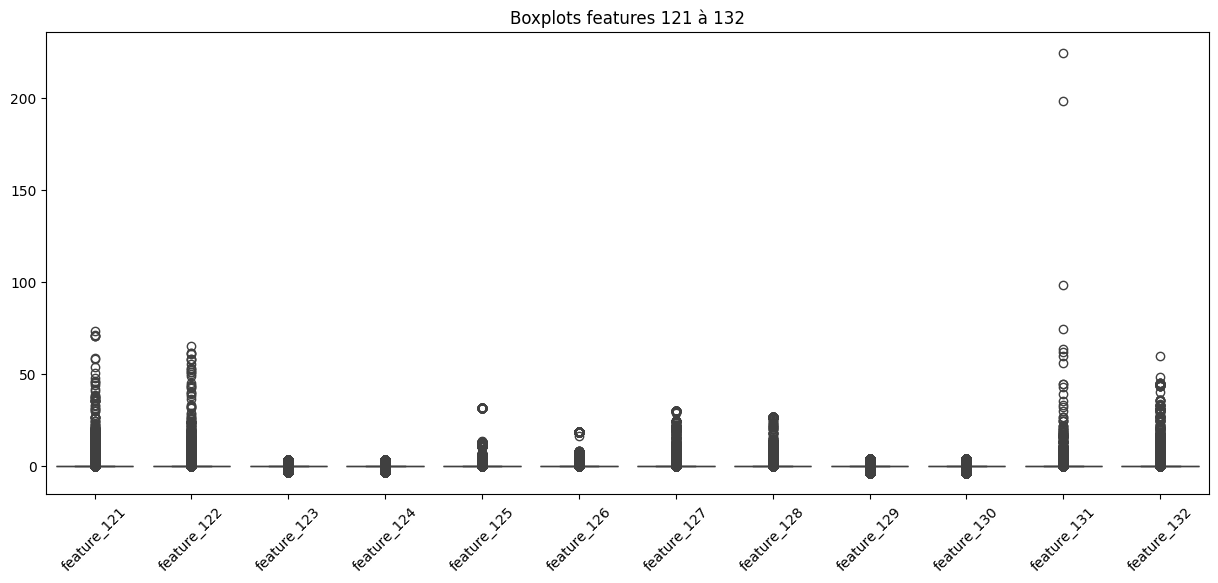

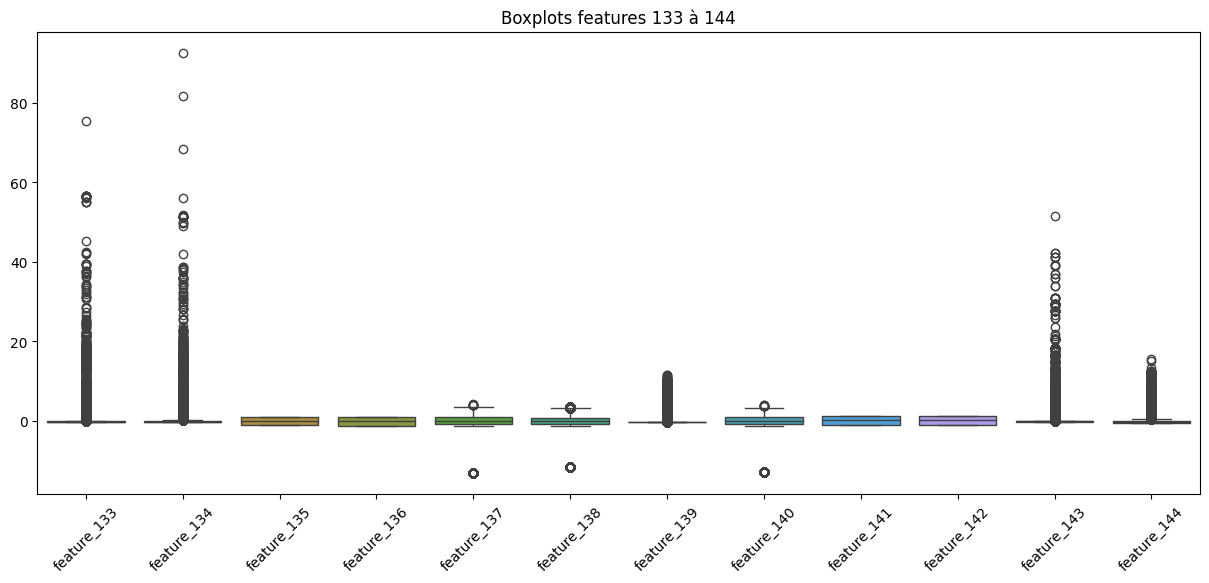

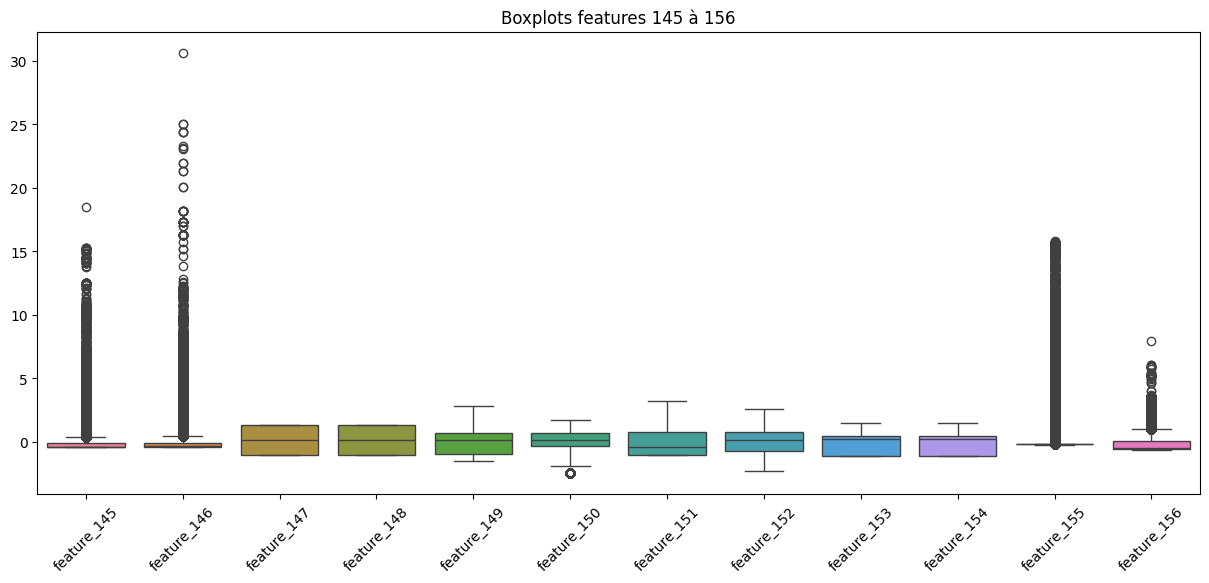

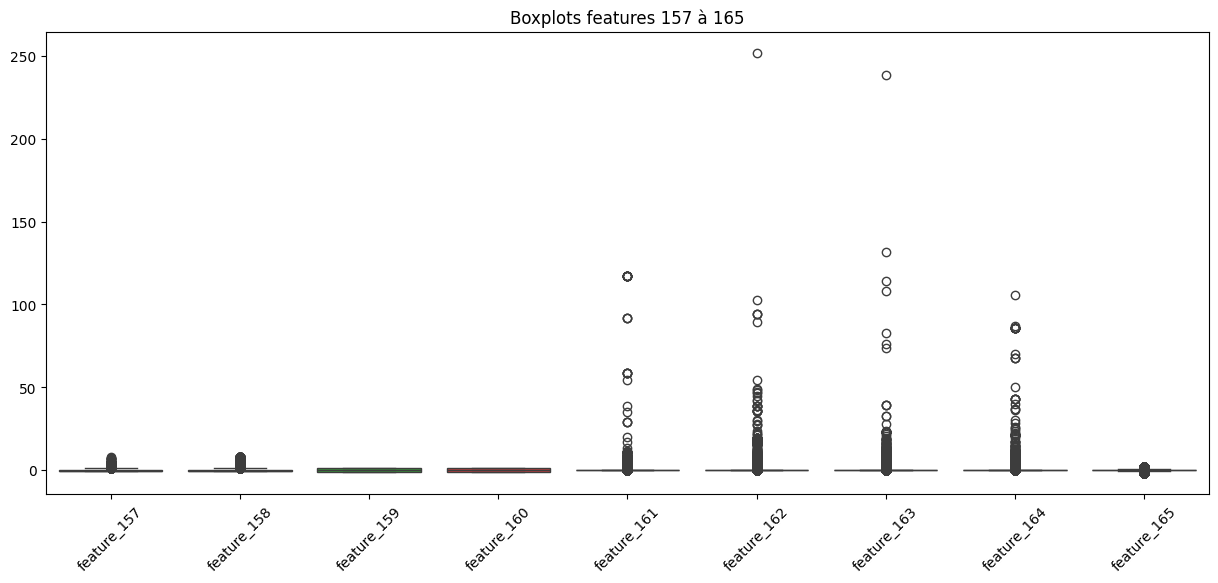

In [5]:
# 🔹 Boxplots par bloc de features (pour éviter l'encombrement)
block_size = 12  # nombre de features à afficher par figure
for i in range(0, len(features), block_size):
    plt.figure(figsize=(15,6))
    sns.boxplot(data=df[features[i:i+block_size]])
    plt.title(f'Boxplots features {i+1} à {min(i+block_size,len(features))}')
    plt.xticks(rotation=45)
    plt.show()

##### par heatmap

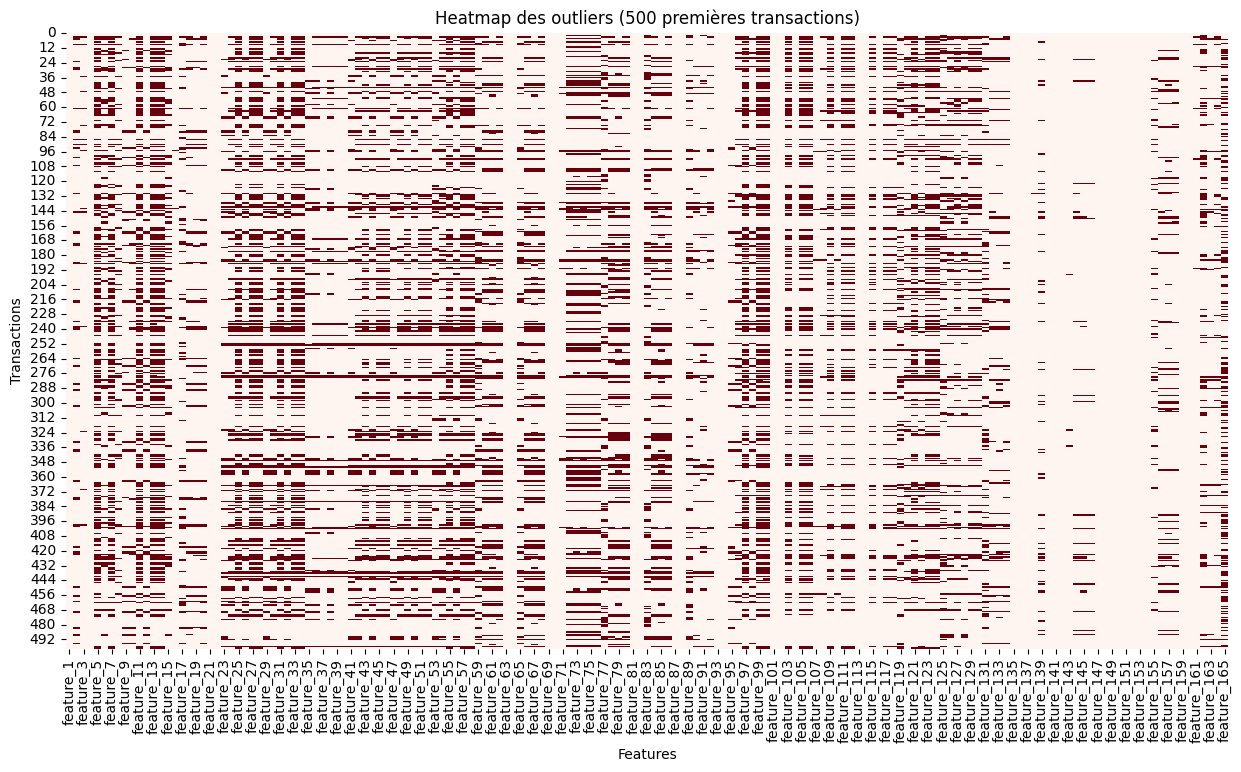

In [6]:
# 🔹 Heatmap synthétique des outliers pour les 500 premières transactions
plt.figure(figsize=(15,8))
sns.heatmap(outliers_mask.iloc[:500, :], cmap='Reds', cbar=False)
plt.title("Heatmap des outliers (500 premières transactions)")
plt.xlabel("Features")
plt.ylabel("Transactions")
plt.show()

#### Visualisation umultivariée

##### PCA 2D 

In [9]:
# 🔹 Sélection des features (on exclut txId et class)
features = [f'feature_{i}' for i in range(1, 166)]
X = df[features].values

# 🔹 Standardisation des données (très important pour PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11176\2539003454.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_pca2[mask,0], X_pca2[mask,1],


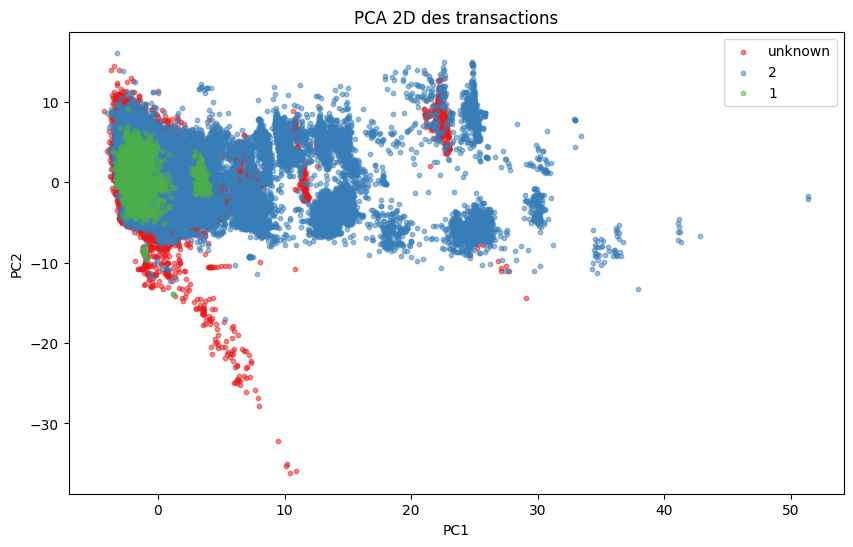

In [14]:
pca_2d = PCA(n_components=2)
X_pca2 = pca_2d.fit_transform(X_scaled)
unique_classes = df['class'].unique()
palette = sns.color_palette("Set1", n_colors=len(unique_classes))
colors = dict(zip(unique_classes, palette))

# Visualisation 2D avec coloration par classe
plt.figure(figsize=(10,6))
for cls in df['class'].unique():
    mask = df['class'] == cls
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1],
                s=10, alpha=0.5, label=cls, c=colors[cls])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D des transactions")
plt.legend()
plt.show()


##### PCA 3D

C:\Users\Admin\AppData\Local\Temp\ipykernel_11176\3471567421.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca3[mask,0], X_pca3[mask,1], X_pca3[mask,2],


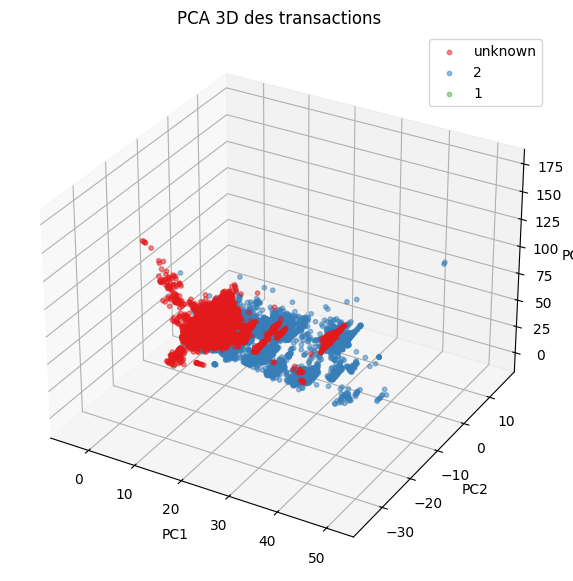

Variance expliquée par les deux premiers composants : 0.16987251998296587
Variance expliquée par les trois premiers composants : 0.22521907123550217


In [15]:
pca_3d = PCA(n_components=3)
X_pca3 = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for cls in classes:
    mask = df['class'] == cls
    ax.scatter(X_pca3[mask,0], X_pca3[mask,1], X_pca3[mask,2],
               s=10, alpha=0.5, label=cls, c=colors[cls])
    
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D des transactions")
ax.legend()
plt.show()

# 🔹 Information : variance expliquée
print("Variance expliquée par les deux premiers composants :",
      np.sum(pca_2d.explained_variance_ratio_))
print("Variance expliquée par les trois premiers composants :",
      np.sum(pca_3d.explained_variance_ratio_))

* les points qui sont loin du nuage principal représentent des transactions dont la combinaison de features est rare ou extrême.

#### detection

* Dans cette étape, nous procédons à la détection des valeurs aberrantes univariées et multivariées afin d’identifier les transactions atypiques du dataset Elliptic. L’objectif est de mieux comprendre la structure des données et de repérer les comportements potentiellement frauduleux, en ajoutant deux indicateurs (is_outlier_univ et is_outlier_multi) pour enrichir l’analyse et améliorer la qualité du modèle.

In [8]:
#Détection des outliers univariés avec IQR
def detect_outliers_iqr(df, features):
    is_outlier_univ = pd.Series(False, index=df.index)  # initialiser à False
    
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        is_outlier_univ |= (df[feature] < lower_bound) | (df[feature] > upper_bound)
    
    return is_outlier_univ

In [9]:
# Choisir les features numériques sur lesquelles appliquer IQR
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
df['is_outlier_univ'] = detect_outliers_iqr(df, numeric_features)

In [10]:
print(df['is_outlier_univ'].sum())

193691


In [11]:
# Détection des outliers multivariés avec Isolation Forest
# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_features])

# Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['is_outlier_multi'] = iso_forest.fit_predict(X_scaled) == -1  # True si outlier

In [12]:
print(df['is_outlier_multi'].sum())

2038


In [13]:
print("Nombre d'outliers univariés :", df['is_outlier_univ'].sum())
print("Nombre d'outliers multivariés :", df['is_outlier_multi'].sum())

# Visualiser un aperçu
print(df[['is_outlier_univ','is_outlier_multi']].head())

Nombre d'outliers univariés : 193691
Nombre d'outliers multivariés : 2038
   is_outlier_univ  is_outlier_multi
0            False             False
1            False             False
2             True             False
3             True             False
4             True             False


In [14]:
X_scaled

array([[ 0.53677517, -1.50565256, -0.17146929, ..., -0.09752359,
        -0.12061341, -0.11979246],
       [-1.49911987, -1.50565256, -0.17148421, ..., -0.09752359,
        -0.12061341, -0.11979246],
       [ 0.5512275 , -1.50565256, -0.17210694, ..., -0.18367056,
        -0.12061341, -0.11979246],
       ...,
       [-0.11547177,  1.6580424 , -0.17201373, ..., -0.09752359,
        -0.12061341, -0.11979246],
       [-0.11294794,  1.6580424 , -0.17284167, ..., -0.14059708,
         1.51969962,  1.52139948],
       [-0.12251631,  1.6580424 , -0.01203726, ..., -0.14059708,
         1.51969962,  1.52139948]])

In [15]:
df.isnull().sum()

txId                0
feature_1           0
feature_2           0
feature_3           0
feature_4           0
                   ..
feature_165         0
feature_166         0
class               0
is_outlier_univ     0
is_outlier_multi    0
Length: 170, dtype: int64

### Sélection initiale de features

##### variance

In [16]:
# Suppression des features quasi-constantes (variance faible)
# ----------------------------
selector = VarianceThreshold(threshold=0.01)  # threshold peut être ajusté
selector.fit(df[numeric_features])
features_var = [feature for feature, keep in zip(numeric_features, selector.get_support()) if keep]

print("Features après suppression variance faible :", len(features_var))

Features après suppression variance faible : 167


##### correlation

In [17]:
# Suppression des features fortement corrélées
# ----------------------------
corr_matrix = df[features_var].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

features_uncorr = [col for col in features_var if not any(upper_tri[col] > 0.9)]
print("Features après suppression corrélations élevées :", len(features_uncorr))

Features après suppression corrélations élevées : 91


##### Mutual Information

In [18]:
# Optionnel : Mutual Information (pour supervision)
# ----------------------------
if 'class' in df.columns:
    mi = mutual_info_classif(df[features_uncorr], df['class'], discrete_features=False)
    mi_series = pd.Series(mi, index=features_uncorr).sort_values(ascending=False)
    # Choisir top N features par MI
    top_features = mi_series.head(30).index.tolist()
    print("Top features selon Mutual Information :", top_features)
else:
    top_features = features_uncorr

Top features selon Mutual Information : ['feature_54', 'feature_60', 'feature_53', 'feature_90', 'feature_24', 'txId', 'feature_3', 'feature_23', 'feature_41', 'feature_108', 'feature_89', 'feature_107', 'feature_143', 'feature_55', 'feature_91', 'feature_72', 'feature_49', 'feature_43', 'feature_59', 'feature_144', 'feature_132', 'feature_128', 'feature_25', 'feature_146', 'feature_138', 'feature_126', 'feature_45', 'feature_96', 'feature_131', 'feature_35']


##### le dataset final

In [19]:
# Créer le dataset final sélectionné 
# ----------------------------
selected_features = features_uncorr + ['is_outlier_univ','is_outlier_multi']
df_selected = df[selected_features].copy()
df_selected['class']=
print("Dataset final avec features sélectionnées :")
print(df_selected.head())

Dataset final avec features sélectionnées :
        txId  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  230425980          1  -0.171469  -0.184668  -1.201369  -0.121970   
1    5530458          1  -0.171484  -0.184668  -1.201369  -0.121970   
2  232022460          1  -0.172107  -0.184668  -1.201369  -0.121970   
3  232438397          1   0.163054   1.963790  -0.646376  12.409294   
4  230460314          1   1.011523  -0.081127  -1.201369   1.153668   

   feature_6  feature_8  feature_11  feature_13  ...  feature_157  \
0  -0.043875  -0.061584   -0.049707   -0.028741  ...    -0.562153   
1  -0.043875  -0.061584   -0.049707   -0.028741  ...     0.947382   
2  -0.043875  -0.061584   -0.049707   -0.028741  ...     0.670883   
3  -0.063725  12.414558    0.043598    1.059993  ...    -0.577099   
4   0.333276  -0.061584    0.935886    1.203038  ...    -0.511871   

   feature_158  feature_159  feature_161  feature_162  feature_163  \
0    -0.600999     1.461330     0.018279    

### Normalisation / standardisation

* df_standardized → pour algos sensibles à la variance

* df_normalized → pour algos sensibles à la distance

In [20]:
#Dataset standardisé (pour algos sensibles à la variance)
# ----------------------------
numeric_cols_selected = df_selected.select_dtypes(include=['int64','float64']).columns.tolist()
scaler_std = StandardScaler()
df_standardized = df_selected.copy()
df_standardized[numeric_cols_selected] = scaler_std.fit_transform(df_standardized[numeric_cols_selected])
df_standardized['class'] = df_selected['class']
# Sauvegarder
df_standardized.to_csv('elliptic_standardized.csv', index=False)
print("Dataset standardisé sauvegardé : elliptic_standardized.csv")

KeyError: 'class'

In [ ]:
numeric_cols_selected = df_selected.select_dtypes(include=['int64','float64']).columns.tolist()

# Dataset normalisé (pour algos sensibles à la distance)
scaler_norm = MinMaxScaler()
df_normalized = df_selected.copy()

# Normalisation uniquement des colonnes numériques
df_normalized[numeric_cols_selected] = scaler_norm.fit_transform(df_normalized[numeric_cols_selected])
df_normalized['class'] = df_selected['class']
# Sauvegarder
df_normalized.to_csv('elliptic_normalized.csv', index=False)
print("Dataset normalisé sauvegardé : elliptic_normalized.csv")

In [37]:
df_standardized.shape

(203769, 93)